In [1]:
import os

In [2]:
import pandas as pd

In [3]:
sdir=r'C:\Users\Anggit\klasifikasi\dataset tumbuhan\DATASET TANAMAN HERBAL\Data Training'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths           labels
0  C:\Users\Anggit\klasifikasi\dataset tumbuhan\D...  Daun Jambu Biji
1  C:\Users\Anggit\klasifikasi\dataset tumbuhan\D...  Daun Jambu Biji
2  C:\Users\Anggit\klasifikasi\dataset tumbuhan\D...  Daun Jambu Biji
3  C:\Users\Anggit\klasifikasi\dataset tumbuhan\D...  Daun Jambu Biji
4  C:\Users\Anggit\klasifikasi\dataset tumbuhan\D...  Daun Jambu Biji
Daun Jambu Biji    80
Daun Kari          80
Daun Kemangi       80
Daun Kunyit        80
Daun Mint          80
Daun Pepaya        80
Daun Sirih         80
Daun Sirsak        80
Teh Hijau          80
Lidah Buaya        79
Name: labels, dtype: int64


In [4]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
# from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
# from sklearn.metrics import confusion_matrix, classification_report
# from IPython.display import display, HTML
from keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import RMSprop

In [5]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  639   test_df length:  80   valid_df length:  80


In [6]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(rescale=1./255,
#                        shear_range=0.1,
                       horizontal_flip=True,
                       vertical_flip=True,
                       rotation_range=15,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       fill_mode='reflect',
                       brightness_range=(0.8,1.2),
#                        zoom_range=0.05,
#                        channel_shift_range=150.0,
                      )
train_gen=gen.flow_from_dataframe( train_df, 
                                  x_col='filepaths', 
                                  y_col='labels', 
                                  target_size=img_size, 
                                  class_mode='categorical',
                                  color_mode='rgb', 
                                  shuffle=True,
                                  batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255,
                            horizontal_flip=True,
                            vertical_flip=True,
#                             zoom_range=0.1,
                           )
valid_gen=validgen.flow_from_dataframe( valid_df, 
                                       x_col='filepaths', 
                                       y_col='labels',
                                       target_size=img_size, 
                                       class_mode='categorical',
                                       color_mode='rgb', 
                                       shuffle=True, 
                                       batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255,
                          shear_range=0.2,
                          zoom_range=0.1,
                          horizontal_flip=True,
                          )
test_gen=testgen.flow_from_dataframe( test_df, 
                                     x_col='filepaths', 
                                     y_col='labels', 
                                     target_size=img_size, 
                                     class_mode='categorical',
                                     color_mode='rgb', 
                                     shuffle=False, 
                                     batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  80   test steps:  1
Found 639 validated image filenames belonging to 10 classes.
Found 80 validated image filenames belonging to 10 classes.
Found 80 validated image filenames belonging to 10 classes.
['Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Lidah Buaya', 'Teh Hijau']


In [7]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<20:  
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

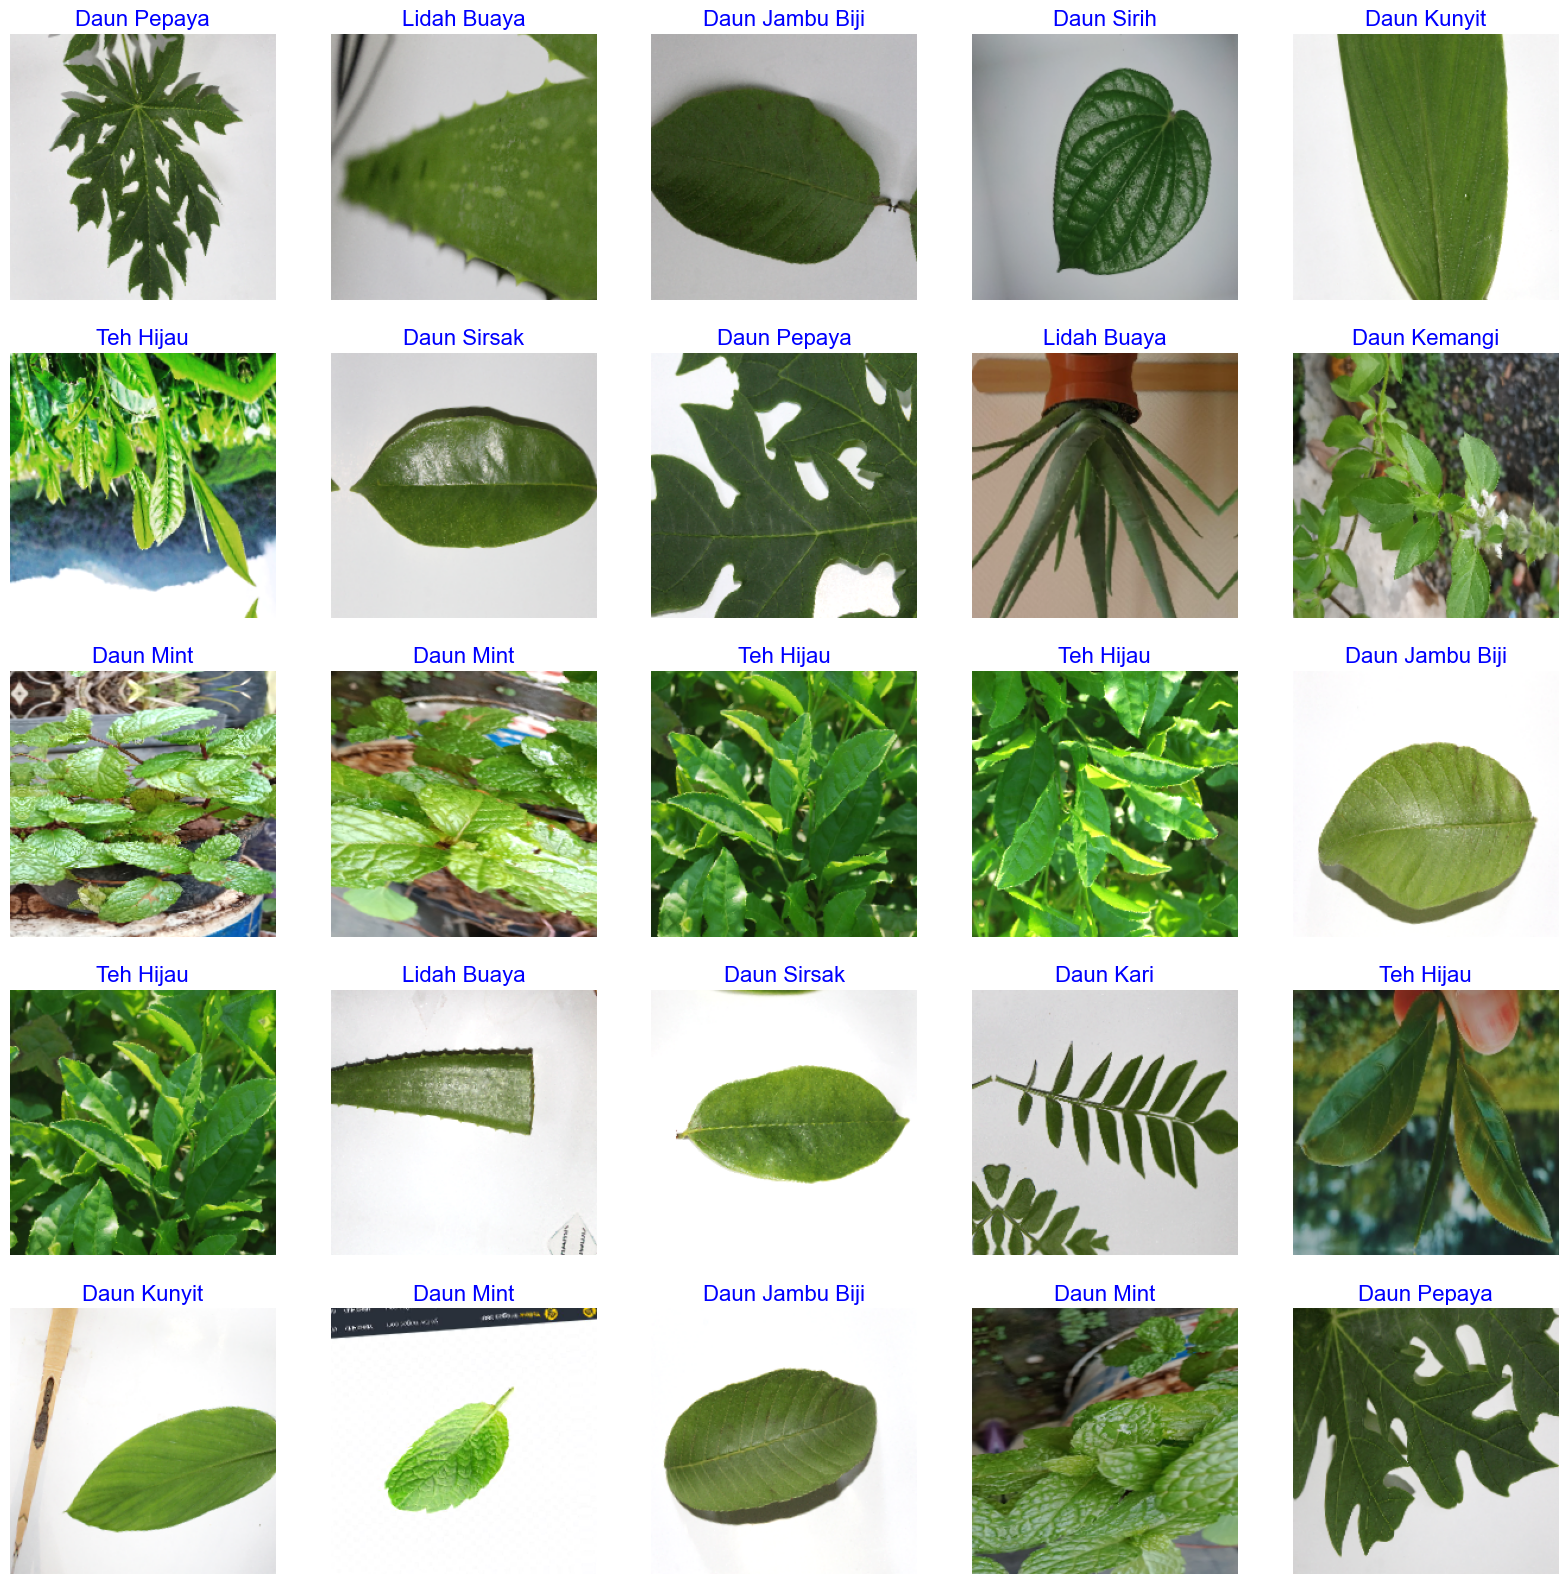

In [8]:
show_image_samples(train_gen)

In [9]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
base_model.trainable = False

In [12]:
model_name= 'Anggit'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Conv2D(filters=64,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Conv2D(filters=128,padding='same', kernel_size = 3, activation='relu', strides= 1),
#     tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x000001B0A2BCB340>


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         7

In [14]:
import random
import matplotlib.image as mpimg

for dirpath, dirnames, filenames in os.walk("Data"):
  print(f"Ada {len(dirnames)} direktori dan {len(filenames)} gambar di dalam {dirpath}")

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Ukuran Gambar:{img.shape}")
  return img

Ukuran Gambar:(3456, 5184, 3)


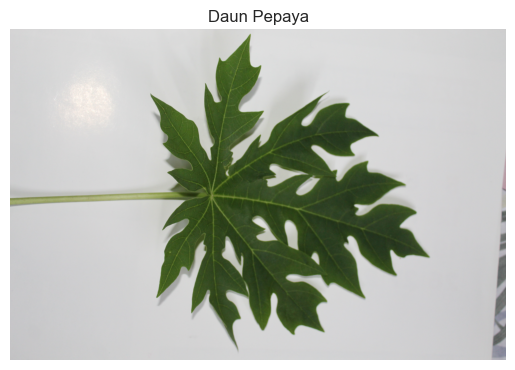

In [15]:
img = view_random_image("dataset tumbuhan/DATASET TANAMAN HERBAL_/Data Training/","Daun Pepaya")

In [16]:
img

array([[[216, 212, 213],
        [214, 210, 211],
        [213, 209, 210],
        ...,
        [206, 204, 205],
        [203, 201, 202],
        [206, 204, 205]],

       [[213, 211, 212],
        [215, 213, 214],
        [214, 212, 213],
        ...,
        [205, 203, 204],
        [205, 203, 204],
        [206, 204, 205]],

       [[212, 210, 211],
        [215, 213, 214],
        [215, 213, 214],
        ...,
        [208, 206, 207],
        [205, 205, 205],
        [204, 204, 204]],

       ...,

       [[197, 199, 198],
        [193, 195, 194],
        [192, 194, 193],
        ...,
        [180, 180, 190],
        [180, 180, 190],
        [178, 178, 188]],

       [[200, 202, 201],
        [194, 196, 195],
        [193, 195, 194],
        ...,
        [179, 179, 187],
        [179, 179, 187],
        [177, 177, 187]],

       [[194, 196, 195],
        [193, 195, 194],
        [195, 197, 196],
        ...,
        [178, 178, 186],
        [178, 178, 186],
        [177, 177, 185]]

In [17]:
epochs = 25

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/25
10/10 [==============================] - 328s 32s/step - loss: 2.2843 - accuracy: 0.1596 - val_loss: 2.2183 - val_accuracy: 0.2750
Epoch 2/25
10/10 [==============================] - 285s 28s/step - loss: 1.9072 - accuracy: 0.3271 - val_loss: 1.6751 - val_accuracy: 0.3000
Epoch 3/25
10/10 [==============================] - 274s 27s/step - loss: 1.3019 - accuracy: 0.4664 - val_loss: 1.1088 - val_accuracy: 0.6125
Epoch 4/25
10/10 [==============================] - 255s 25s/step - loss: 0.9794 - accuracy: 0.6182 - val_loss: 1.0138 - val_accuracy: 0.5750
Epoch 5/25
10/10 [==============================] - 256s 25s/step - loss: 0.7231 - accuracy: 0.7058 - val_loss: 0.6742 - val_accuracy: 0.7625
Epoch 6/25
10/10 [==============================] - 257s 25s/step - loss: 0.5529 - accuracy: 0.7856 - val_loss: 0.4355 - val_accuracy: 0.9125
Epoch 7/25
10/10 [==============================] - 255s 25s/step - loss: 0.4202 - accuracy: 0.8482 - val_loss: 0.3181 - val_accuracy: 0.9125
Epoch 

In [18]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    #plot
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.legend()

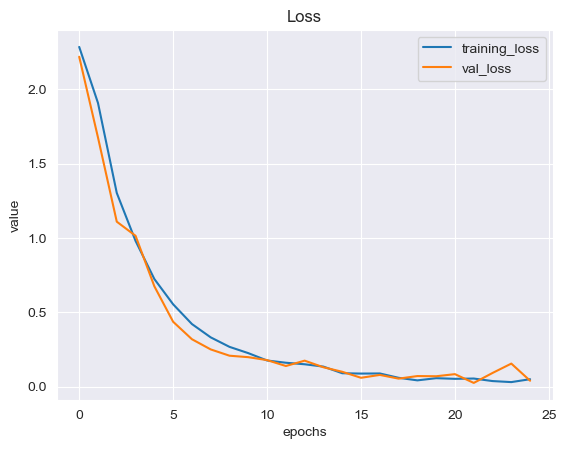

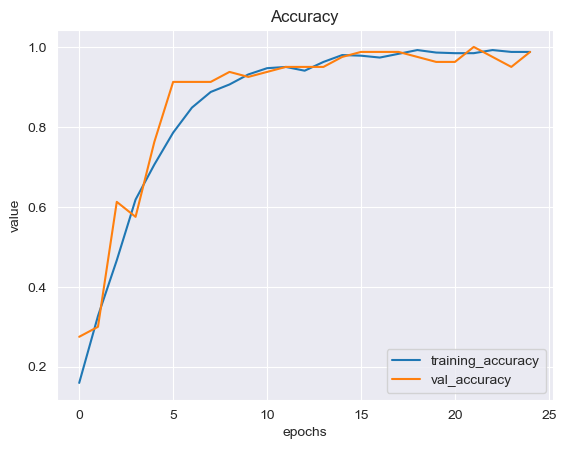

In [19]:
plot_loss_curves(history)

In [21]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "medium_project"
SAVE_MODEL_NAME = "modelAv4-vmodifdata4-7-3.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path,include_optimizer=False)

Saving Model At model\medium_project\modelAv4-vmodifdata4-7-3.h5...
